In [1]:
#----------------------------------------------------------#

import numpy as np
import pandas as pd

#----------------------------------------------------------#

import seaborn as sns
import matplotlib.pyplot as plt

#----------------------------------------------------------#

from sklearn.metrics import (confusion_matrix,
                             classification_report,
                             ConfusionMatrixDisplay)

#-----------------------torch imports-----------------------------------#

import torch
import torch.nn as nn
#import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
import torchsummary

In [3]:

print(f'PyTorch Version: {torch.__version__}')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Current Device: {device}.')

PyTorch Version: 2.1.1+cu121
Current Device: cuda.


In [4]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 1000

In [5]:
#parameters

batch_size = 128


learning_rate = 0.001 # Learning rate
mom=0.9 #momentum
epochs = 100

train_accuracies = []
train_losses = []

test_accuracies = []
test_losses = []

In [6]:
def accuracy(y_hat, y_true):
    correct = torch.eq(y_hat, y_true).sum().item()
    accuracy = (correct / len(y_true))
    return accuracy

In [7]:
from torchvision.datasets import FashionMNIST


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.2860,), (0.3530,))  # FMNIST mean/std
])
train_ds = FashionMNIST('./data', train=True,  download=True, transform=transform)
test_ds  = FashionMNIST('./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  )
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, )

In [8]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
images = (images.numpy().transpose((0, 2, 3, 1)) * std + mean).clip(0, 1)

num_images = min(len(images), 16)
rows = 4 
fig, axes = plt.subplots(rows, 4, figsize = (15, 4 * rows)) 

for i, ax in enumerate(axes.flat):
    if i < num_images:
        ax.imshow(images[i])
        ax.set_title(f'Label: {train_ds.classes[labels[i]]}', fontsize = 15, fontweight = 'bold')
        ax.axis('off')

for ax in axes.flat[num_images:]:
    ax.axis('off')

plt.tight_layout(pad = 1)
plt.savefig('test.jpeg', dpi = 500)
plt.show()

In [28]:
#Simple Model
# The arguments channels implies Filter count
# refer to https://madebyollin.github.io/convnet-calculator/
import torch
import torch.nn as nn
import torch.nn.functional as F

class ANN(nn.Module):
    def __init__(self, channels: int):
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv2d(1, channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(channels),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 14x14

            nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(channels),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 7x7

            nn.Flatten(),
            nn.Linear(channels * 7 * 7, channels * 4 * 4, bias=False),
            nn.ReLU(),

            nn.Linear(channels * 4 * 4, 10, bias=False),
            nn.ReLU()  # This ReLU mimics the output IFNode (you may remove it if softmax is applied)
        )

    def forward(self, x: torch.Tensor):
        return self.model(x)

In [29]:
net=ANN(channels=128)

In [30]:
model=net.cuda()

In [31]:
print(model)

ANN(
  (model): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=6272, out_features=2048, bias=False)
    (10): ReLU()
    (11): Linear(in_features=2048, out_features=10, bias=False)
    (12): ReLU()
  )
)


In [32]:
#torch Info Gives more information than asic Print Model
from torchinfo import summary


summary(net, input_size=(batch_size, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
ANN                                      [128, 10]                 --
├─Sequential: 1-1                        [128, 10]                 --
│    └─Conv2d: 2-1                       [128, 128, 28, 28]        1,152
│    └─BatchNorm2d: 2-2                  [128, 128, 28, 28]        256
│    └─ReLU: 2-3                         [128, 128, 28, 28]        --
│    └─MaxPool2d: 2-4                    [128, 128, 14, 14]        --
│    └─Conv2d: 2-5                       [128, 128, 14, 14]        147,456
│    └─BatchNorm2d: 2-6                  [128, 128, 14, 14]        256
│    └─ReLU: 2-7                         [128, 128, 14, 14]        --
│    └─MaxPool2d: 2-8                    [128, 128, 7, 7]          --
│    └─Flatten: 2-9                      [128, 6272]               --
│    └─Linear: 2-10                      [128, 2048]               12,845,056
│    └─ReLU: 2-11                        [128, 2048]               

In [33]:
#------------------------- Loss and optim----------
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate ,momentum=mom)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=epochs)

In [ ]:
#   Attempt to resume from a saved checkpoint 
# Not for First Run

# 1) Rebuild your model, optimizer, scheduler exactly as before:
model     = ANN(channels=128).to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=mom)
scheduler = CosineAnnealingLR(optimizer, T_max=epochs)

# 2) Load the checkpoint
ckpt = torch.load('checkpoint_full.pth', map_location=device)

# 3) Restore everything
start_epoch    = ckpt['epoch'] + 1
model.load_state_dict(ckpt['model_state'])
optimizer.load_state_dict(ckpt['optimizer_state'])
scheduler.load_state_dict(ckpt['scheduler_state'])

max_test_acc   = ckpt['best_acc']
train_losses   = ckpt['train_losses']
train_accuracies = ckpt['train_accs']
test_losses    = ckpt['test_losses']
test_accuracies = ckpt['test_accs']

print(f"Resuming from epoch {start_epoch}, best_val_acc = {max_test_acc:.4f}")

FileNotFoundError: [Errno 2] No such file or directory: 'checkpoint_full.pth'

In [36]:
# Trainning
import os
import time
from tqdm.auto import tqdm



torch.manual_seed(0) # depends on exp
max_test_acc = -1
out_dir = os.path.join('')
for epoch in tqdm(range(epochs)):
    start_time = time.time()

    train_accuracy = 0.0
    train_loss = 0.0

    model.train()

    for idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        y_hat = model(inputs)
        loss = criterion(y_hat, labels)
        # loss.backward()
        loss.backward()
        optimizer.step()

        predictions = torch.argmax(torch.softmax(y_hat, dim=1), dim=1)
        train_accuracy += accuracy(predictions, labels)
        train_loss += loss.item()
        

    train_accuracy /= len(train_loader)
    train_accuracies.append(train_accuracy)

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    lr_scheduler.step()

    test_accuracy = 0.0
    test_loss = 0.0

    model.eval()

    with torch.inference_mode():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            y_hat = model(inputs)
            loss = criterion(y_hat, labels)

            predictions = torch.argmax(torch.softmax(y_hat, dim=1), dim=1)
            test_accuracy += accuracy(predictions, labels)
            test_loss += loss.item()
            
        test_accuracy /= len(test_loader)
        test_accuracies.append(test_accuracy)

        test_loss /= len(test_loader)
        test_losses.append(test_loss)

    elapsed_time = time.time() - start_time

    #lr = optimizer.param_groups[0]['lr']
    lr = lr_scheduler.get_last_lr()



    print(f'Epoch {epoch + 1}/{epochs} | Learning Rate: {lr}')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Val Loss: {test_loss:.4f}, Val Accuracy: {test_accuracy:.4f}')
    print(f'Elapsed Time: {elapsed_time:.2f} seconds\n')

    #lr_scheduler.step(test_loss)
    save_max = False
    if test_accuracy > max_test_acc:
        max_test_acc = test_accuracy
        save_max = True

    checkpoint = {
        'epoch':            epoch,
        'model_state':      model.state_dict(),
        'optimizer_state':  optimizer.state_dict(),
        'scheduler_state':  lr_scheduler.state_dict(),
        'best_acc':         max_test_acc,
        'train_losses':     train_losses,
        'train_accs':       train_accuracies,
        'test_losses':      test_losses,
        'test_accs':        test_accuracies
    }

    if save_max:
        torch.save(checkpoint, os.path.join(out_dir, 'checkpoint_max.pth'))

    torch.save(checkpoint, os.path.join(out_dir, 'checkpoint_full.pth'))


    if test_accuracy >= 0.99:
        print('\nDesired Accuracy Achieved!')
        break
    

  0%|          | 0/100 [00:00<?, ?it/s]

c:\Program Files\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1/100 | Learning Rate: [0.0009997532801828658]
Train Loss: 0.5871, Train Accuracy: 0.8006
Val Loss: 0.3711, Val Accuracy: 0.8682
Elapsed Time: 11.21 seconds

Epoch 2/100 | Learning Rate: [0.0009990133642141358]
Train Loss: 0.3165, Train Accuracy: 0.8892
Val Loss: 0.3271, Val Accuracy: 0.8813
Elapsed Time: 10.59 seconds

Epoch 3/100 | Learning Rate: [0.00099778098230154]
Train Loss: 0.2746, Train Accuracy: 0.9037
Val Loss: 0.2873, Val Accuracy: 0.8968
Elapsed Time: 10.44 seconds

Epoch 4/100 | Learning Rate: [0.000996057350657239]
Train Loss: 0.2450, Train Accuracy: 0.9138
Val Loss: 0.2789, Val Accuracy: 0.9021
Elapsed Time: 10.39 seconds

Epoch 5/100 | Learning Rate: [0.0009938441702975688]
Train Loss: 0.2266, Train Accuracy: 0.9216
Val Loss: 0.2674, Val Accuracy: 0.9044
Elapsed Time: 10.35 seconds

Epoch 6/100 | Learning Rate: [0.0009911436253643444]
Train Loss: 0.2083, Train Accuracy: 0.9272
Val Loss: 0.2508, Val Accuracy: 0.9090
Elapsed Time: 10.40 seconds

Epoch 7/100 | Learn

In [38]:
#### Loading The model for Testing

device = 'cuda' if torch.cuda.is_available() else 'cpu'

#  Rebuild the exact same model class & instantiate
model = ANN(channels=128).to(device)

#  Load your checkpoint
ckpt = torch.load('checkpoint_max.pth', map_location=device)
model.load_state_dict(ckpt['model_state'])      # <<< pull only the 'weights/Model' dict
model.eval()

ANN(
  (model): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=6272, out_features=2048, bias=False)
    (10): ReLU()
    (11): Linear(in_features=2048, out_features=10, bias=False)
    (12): ReLU()
  )
)

In [39]:
true_labels = []
predicted_labels = []



with torch.inference_mode():
    for inputs, labels in tqdm(test_loader):
        inputs, labels = inputs.to(device), labels.to(device)       
        y_hat = model(inputs)
        predictions = torch.argmax(torch.softmax(y_hat, dim=1), dim=1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predictions.cpu().numpy())
        
print(f'Test Accuracy Score: {accuracy(torch.tensor(predicted_labels), torch.tensor(true_labels))*100:.2f} %')

class_labels = list(test_ds.classes)

print(f'Classification Report (Test) --> \n\n' + \
f'{classification_report(true_labels, predicted_labels, target_names = class_labels)}')

  0%|          | 0/79 [00:00<?, ?it/s]

Test Accuracy Score: 92.35 %
Classification Report (Test) --> 

              precision    recall  f1-score   support

 T-shirt/top       0.87      0.90      0.89      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.89      0.88      0.88      1000
       Dress       0.92      0.93      0.92      1000
        Coat       0.85      0.90      0.87      1000
      Sandal       0.98      0.98      0.98      1000
       Shirt       0.81      0.74      0.77      1000
     Sneaker       0.97      0.97      0.97      1000
         Bag       0.99      0.98      0.98      1000
  Ankle boot       0.97      0.97      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [41]:
_, ax = plt.subplots(ncols=2, figsize=(15, 6))

    # accuracy

ax[0].plot(train_accuracies, marker='o', color='blue', markersize=7)
ax[0].plot(test_accuracies, marker='x', color='red', markersize=7)
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'])
ax[0].grid(alpha=0.2)

    # loss

ax[1].plot(train_losses, marker='o', color='blue', markersize=7)
ax[1].plot(test_losses, marker='x', color='red', markersize=7)
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'])

ax[1].grid(alpha=0.2)
plt.savefig('Accuracy and loss.png', dpi=1000)
plt.show()

<Figure size 10000x10000 with 0 Axes>

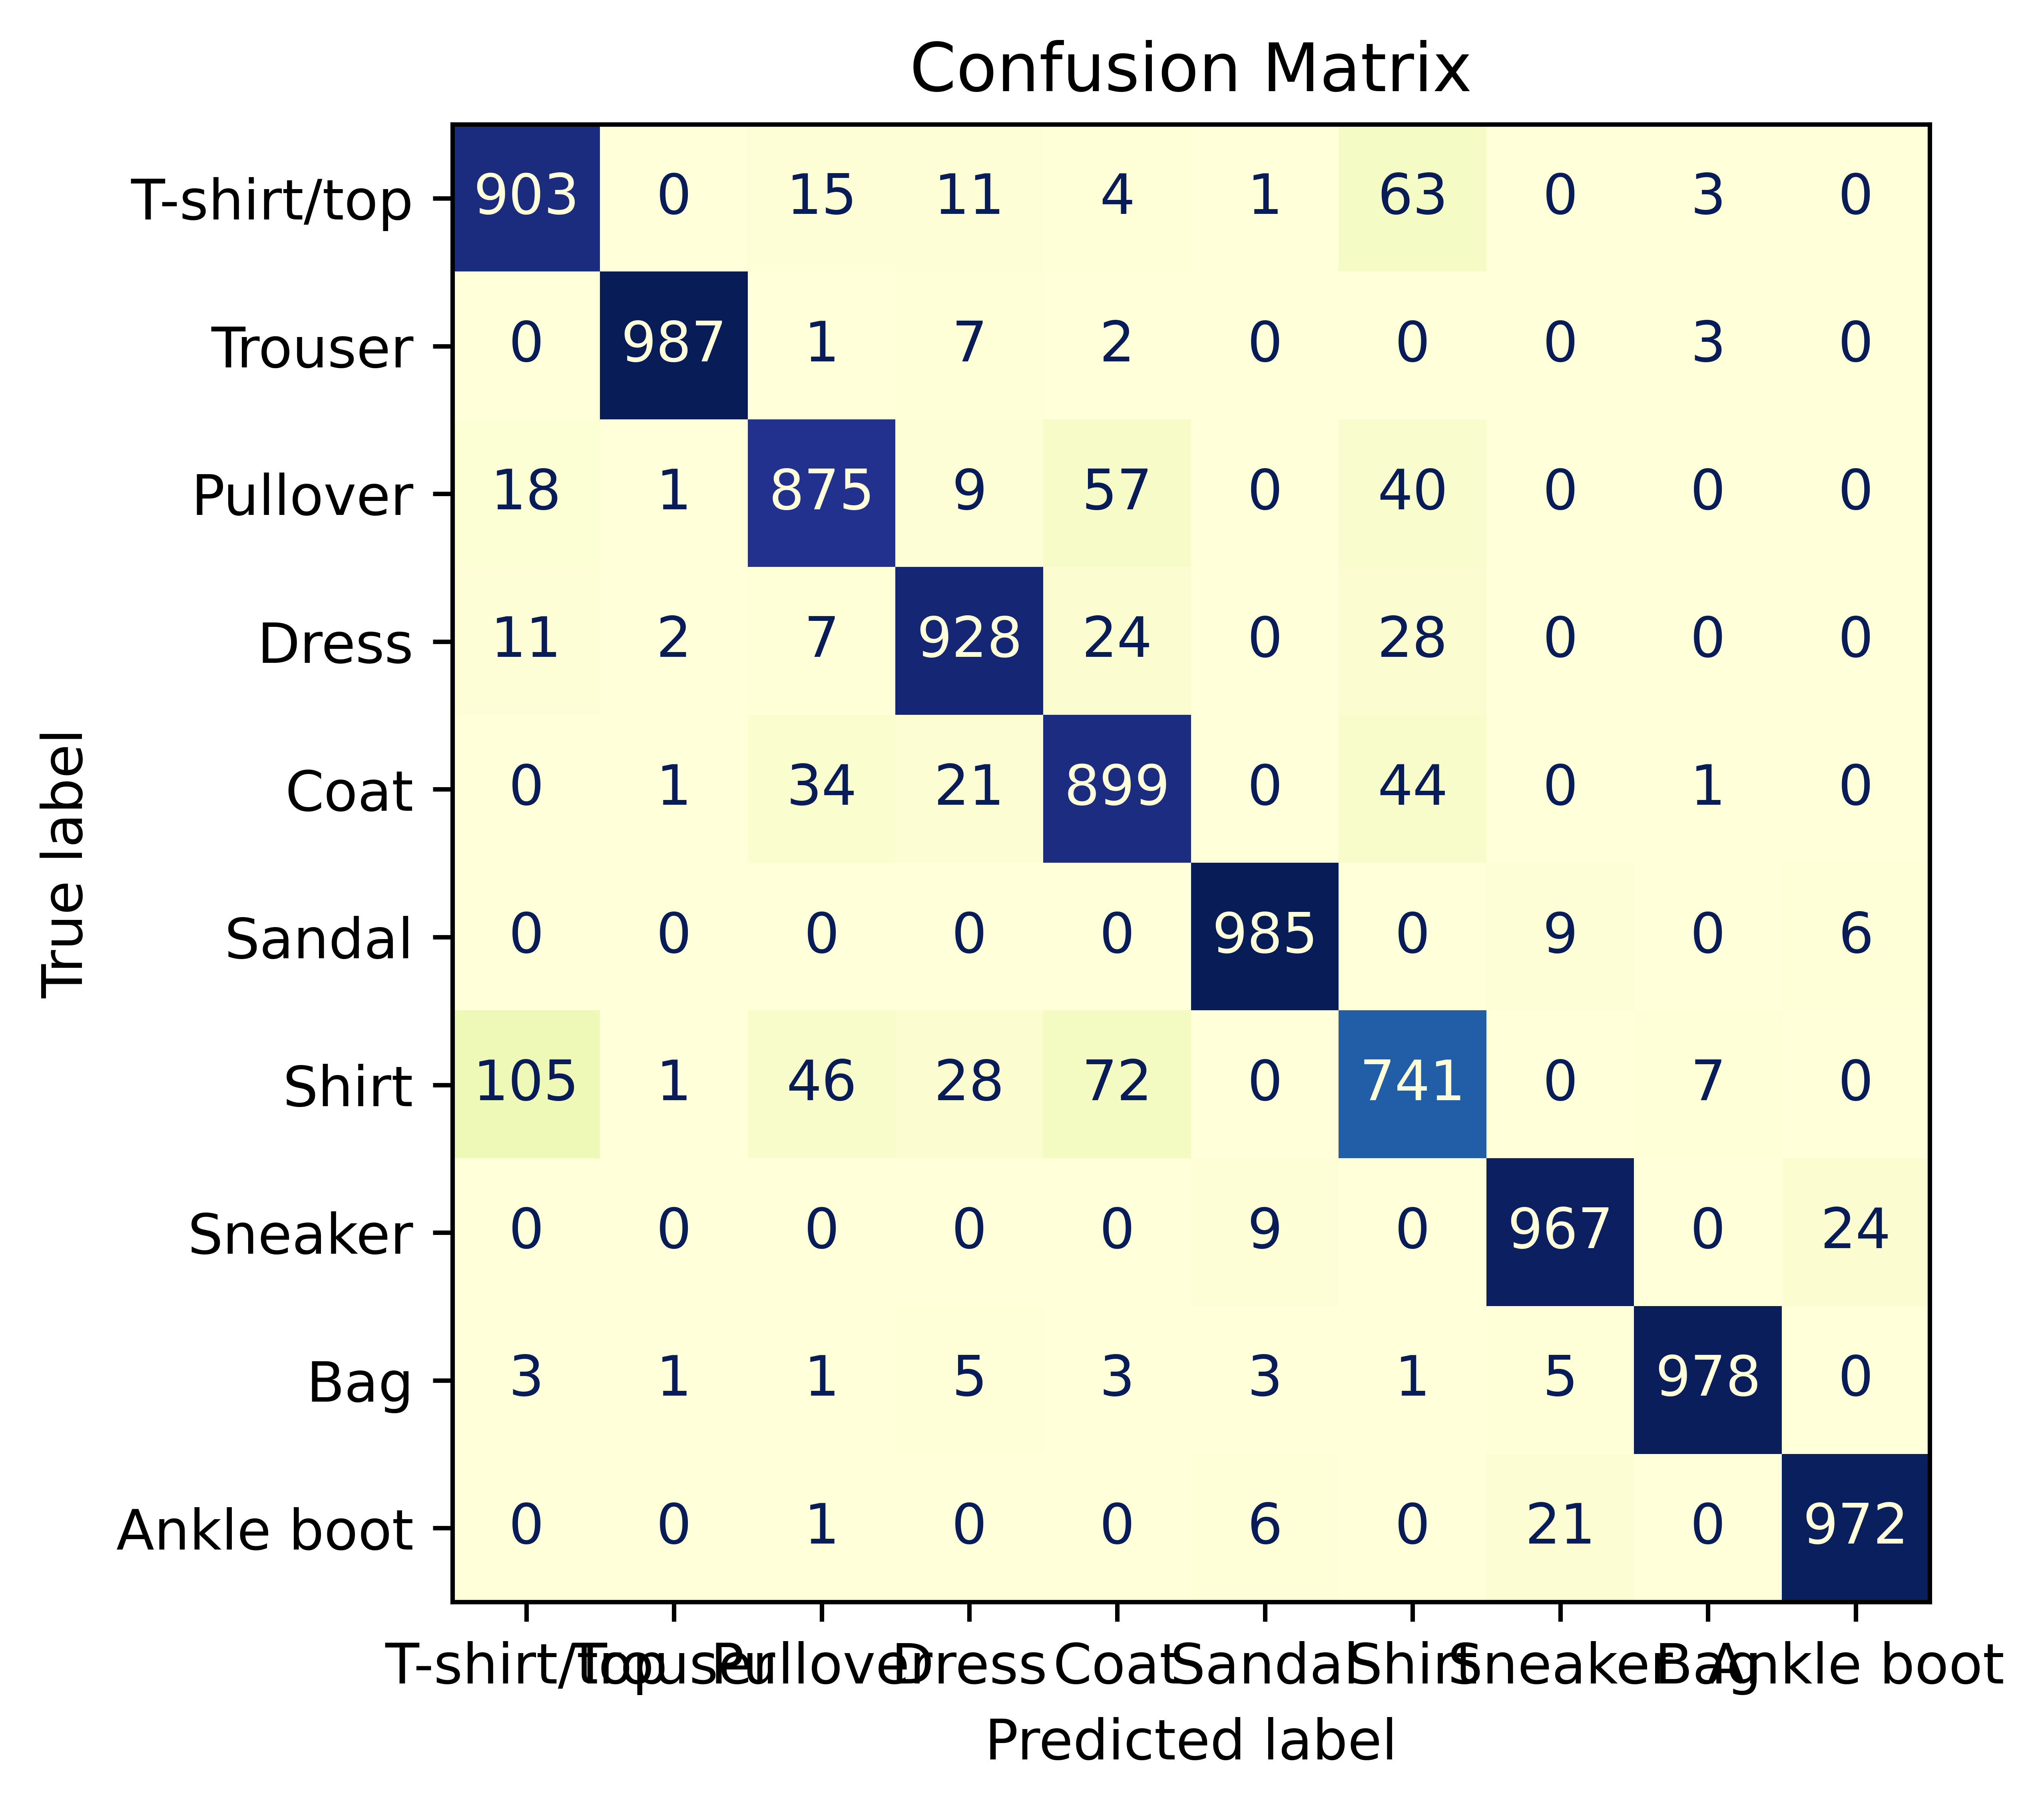

In [42]:
test_matrix = confusion_matrix(true_labels, predicted_labels)

disp_test = ConfusionMatrixDisplay(confusion_matrix=test_matrix, display_labels=class_labels)

plt.figure(figsize=(10, 10))

disp_test.plot(cmap='YlGnBu', colorbar=False)
plt.title('Confusion Matrix')

plt.savefig('Confusion.png', dpi=1000)
plt.show()